<a href="https://colab.research.google.com/github/Boso123/MLcourseFatiga/blob/master/randomforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparación de datos

Se importa todas las libreria para el analisis, carga de datos y entrenamientos



In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
%matplotlib inline
#Evaluations
from sklearn.metrics import classification_report, confusion_matrix
#Random forest
from sklearn.ensemble import RandomForestClassifier
# Tensorflow
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Carga la base de datos en formato CSV y imprime las primeros cinco lineas de datos y la descripción de los datos

In [0]:
sleep_Data = pd.read_csv("/content/drive/My Drive/MicrosuenosData/data.csv")
sleep_Data.head()

,id,image,time,initial_time,pitch,yaw,roll,pitchs,yawns,tag
0,1,/images/image1.jpg,2020-01-22T17:22:08.135000,2020-01-22T17:22:07.443000,10.746500,-33.467357,-3.569197,0,42,untagged
1,2,/images/image2.jpg,2020-01-22T17:22:08.367000,2020-01-22T17:22:07.443000,12.180362,-34.306218,-4.846204,0,42,untagged
2,3,/images/image3.jpg,2020-01-22T17:22:08.599000,2020-01-22T17:22:07.443000,11.764933,-32.793980,-4.018201,0,42,untagged
3,4,/images/image4.jpg,2020-01-22T17:22:07.443000,2020-01-22T17:22:07.443000,15.753147,-29.482020,-5.783584,0,42,untagged
4,5,/images/image5.jpg,2020-01-22T17:22:07.672000,2020-01-22T17:22:07.443000,15.288966,-29.170070,-2.748542,0,42,untagged


In [0]:
sleep_Data.describe()

,id,pitch,yaw,roll,pitchs,yawns
count,9120.000000,9120.000000,9120.000000,9120.000000,9120.0,9120.000000
mean,4560.500000,20.021266,-26.296021,-7.484727,0.0,12.238816
std,2632.861561,13.580649,23.710786,12.668202,0.0,14.363362
min,1.000000,-25.995724,-67.263201,-178.874990,0.0,0.000000
25%,2280.750000,12.712986,-44.984264,-14.023109,0.0,2.000000
50%,4560.500000,19.684845,-31.091948,-8.519872,0.0,8.000000
75%,6840.250000,26.443946,-14.156473,-2.655539,0.0,18.000000
max,9120.000000,94.058592,61.573714,179.925438,0.0,98.000000


Dado a que los pitchs se han capturado de forma incorrecta se eliminara esta variable para el entrenamiento y se designa la columna Id como el identificador

In [0]:
to_drop = ['pitchs']

sleep_Data.drop(to_drop, inplace=True, axis=1)

sleep_Data['id'].is_unique
sleep_Data = sleep_Data.set_index('id')

sleep_Data.head()

,image,time,initial_time,pitch,yaw,roll,yawns,tag
id,,,,,,,,
1,/images/image1.jpg,2020-01-22T17:22:08.135000,2020-01-22T17:22:07.443000,10.746500,-33.467357,-3.569197,42,untagged
2,/images/image2.jpg,2020-01-22T17:22:08.367000,2020-01-22T17:22:07.443000,12.180362,-34.306218,-4.846204,42,untagged
3,/images/image3.jpg,2020-01-22T17:22:08.599000,2020-01-22T17:22:07.443000,11.764933,-32.793980,-4.018201,42,untagged
4,/images/image4.jpg,2020-01-22T17:22:07.443000,2020-01-22T17:22:07.443000,15.753147,-29.482020,-5.783584,42,untagged
5,/images/image5.jpg,2020-01-22T17:22:07.672000,2020-01-22T17:22:07.443000,15.288966,-29.170070,-2.748542,42,untagged


In [0]:
sleep_Data.describe()

,pitch,yaw,roll,yawns
count,9120.000000,9120.000000,9120.000000,9120.000000
mean,20.021266,-26.296021,-7.484727,12.238816
std,13.580649,23.710786,12.668202,14.363362
min,-25.995724,-67.263201,-178.874990,0.000000
25%,12.712986,-44.984264,-14.023109,2.000000
50%,19.684845,-31.091948,-8.519872,8.000000
75%,26.443946,-14.156473,-2.655539,18.000000
max,94.058592,61.573714,179.925438,98.000000


Se remplazan los valores de los tags por valores numericos


*   Sin etiqueta: 0
*   Dormido: 1



In [0]:
sleep_Data = sleep_Data.replace('untagged', 0)
sleep_Data = sleep_Data.replace('dormido', 1)
sleep_Data.describe()

,pitch,yaw,roll,yawns,tag
count,9120.000000,9120.000000,9120.000000,9120.000000,9120.000000
mean,20.021266,-26.296021,-7.484727,12.238816,0.236842
std,13.580649,23.710786,12.668202,14.363362,0.425168
min,-25.995724,-67.263201,-178.874990,0.000000,0.000000
25%,12.712986,-44.984264,-14.023109,2.000000,0.000000
50%,19.684845,-31.091948,-8.519872,8.000000,0.000000
75%,26.443946,-14.156473,-2.655539,18.000000,0.000000
max,94.058592,61.573714,179.925438,98.000000,1.000000


In [0]:
sleep_Data['initial_time'] = pd.to_datetime(sleep_Data['initial_time'])
sleep_Data['time'] = pd.to_datetime(sleep_Data['time'])
sleep_Data.head()

,image,time,initial_time,pitch,yaw,roll,yawns,tag
id,,,,,,,,
1,/images/image1.jpg,2020-01-22 17:22:08.135,2020-01-22 17:22:07.443,10.746500,-33.467357,-3.569197,42,0
2,/images/image2.jpg,2020-01-22 17:22:08.367,2020-01-22 17:22:07.443,12.180362,-34.306218,-4.846204,42,0
3,/images/image3.jpg,2020-01-22 17:22:08.599,2020-01-22 17:22:07.443,11.764933,-32.793980,-4.018201,42,0
4,/images/image4.jpg,2020-01-22 17:22:07.443,2020-01-22 17:22:07.443,15.753147,-29.482020,-5.783584,42,0
5,/images/image5.jpg,2020-01-22 17:22:07.672,2020-01-22 17:22:07.443,15.288966,-29.170070,-2.748542,42,0


In [0]:
#Print all columns of the data set
print(sleep_Data.columns)
print(sleep_Data.dtypes)

Index(['image', 'time', 'initial_time', 'pitch', 'yaw', 'roll', 'yawns',
       'tag'],
      dtype='object')
image                   object
time            datetime64[ns]
initial_time    datetime64[ns]
pitch                  float64
yaw                    float64
roll                   float64
yawns                    int64
tag                      int64
dtype: object


In [0]:
to_drop = ['time', 'initial_time']

sleep_Data.drop(to_drop, inplace=True, axis=1)
sleep_Data.head()

,image,pitch,yaw,roll,yawns,tag
id,,,,,,
1,/images/image1.jpg,10.746500,-33.467357,-3.569197,42,0
2,/images/image2.jpg,12.180362,-34.306218,-4.846204,42,0
3,/images/image3.jpg,11.764933,-32.793980,-4.018201,42,0
4,/images/image4.jpg,15.753147,-29.482020,-5.783584,42,0
5,/images/image5.jpg,15.288966,-29.170070,-2.748542,42,0


# Analisis de los datos

Se chekea que ninguna de las variables contengan valores nulos

In [0]:
sleep_Data.isnull().any()

image    False
pitch    False
yaw      False
roll     False
yawns    False
tag      False
dtype: bool

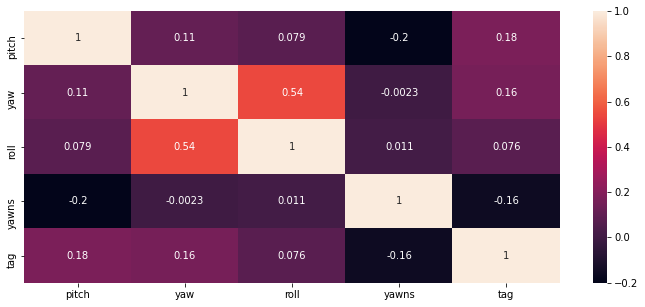

In [0]:
plt.figure(figsize=(12,5))
sns.heatmap(sleep_Data.corr(), annot=True )

Conteo de las etiquetas en el data set. Se logra apreciar que la cantidad de objectos sin etiquetas es bastante alta

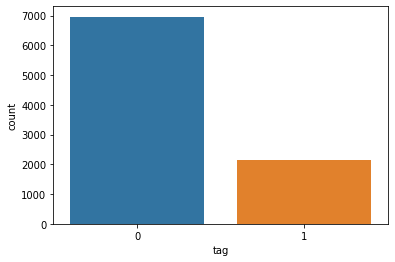

In [0]:
sns.countplot(x='tag', data=sleep_Data)

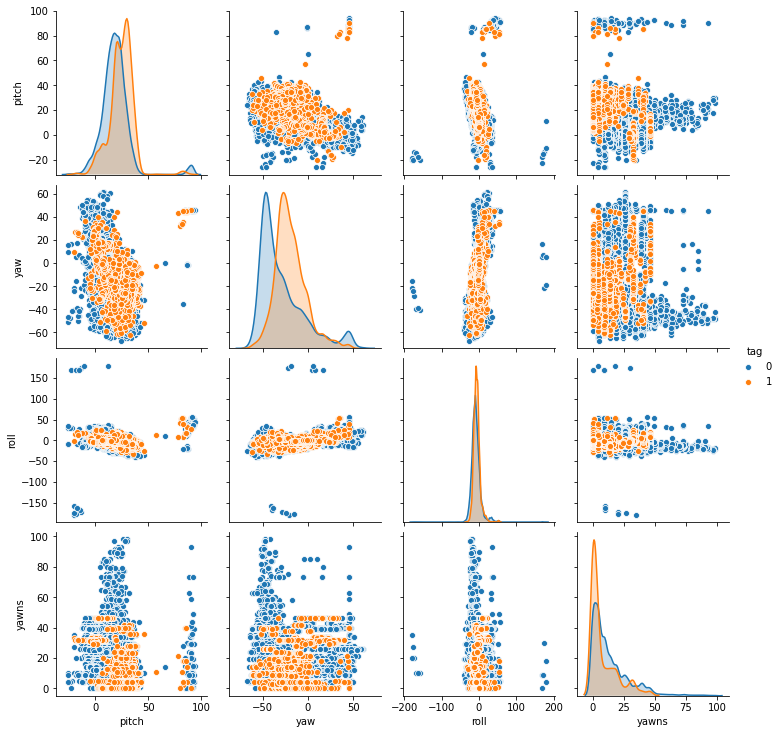

In [0]:
sns.pairplot(data=sleep_Data, hue='tag')

# Preparación de los conjuntos para el entrenamiento

Para mantener el dataset original intacto se crea una copia del objecto

In [0]:
df = sleep_Data.copy()
df.head(5)

,image,pitch,yaw,roll,yawns,tag
id,,,,,,
1,/images/image1.jpg,10.746500,-33.467357,-3.569197,42,0
2,/images/image2.jpg,12.180362,-34.306218,-4.846204,42,0
3,/images/image3.jpg,11.764933,-32.793980,-4.018201,42,0
4,/images/image4.jpg,15.753147,-29.482020,-5.783584,42,0
5,/images/image5.jpg,15.288966,-29.170070,-2.748542,42,0


In [0]:
df.columns

Index(['image', 'pitch', 'yaw', 'roll', 'yawns', 'tag'], dtype='object')

In [0]:
def data_prep(df):
  feature_columns = df.columns[1:-1]
  df_features = pd.DataFrame(data=df, columns=feature_columns)
  return df_features

df_features = data_prep(df)
df_features.head()

,pitch,yaw,roll,yawns
id,,,,
1,10.746500,-33.467357,-3.569197,42
2,12.180362,-34.306218,-4.846204,42
3,11.764933,-32.793980,-4.018201,42
4,15.753147,-29.482020,-5.783584,42
5,15.288966,-29.170070,-2.748542,42


Se divide la data en el set de entrenamiento y testeo del modelo

In [0]:
X = df_features.copy()
y = df['tag'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Se crea un Escalador estandar

In [0]:
def standardScaling(feature):
  scaler = StandardScaler().fit(feature)
  scaled_feature = scaler.transform(feature)
  scaled_feat = pd.DataFrame(data = scaled_feature, columns=df_features.columns)
  return scaled_feat

X_train_scaled = standardScaling(X_train)
X_test_scaled = standardScaling(X_test)

X_train_scaled.head()

,pitch,yaw,roll,yawns
0,0.903127,0.224882,-0.411152,-0.712710
1,-0.789042,0.495683,0.436004,-0.852431
2,0.946705,0.435233,-0.029727,-0.712710
3,-0.030556,-0.992184,-0.950656,1.243383
4,0.062704,-0.854991,-0.803286,-0.503129


Durante el escalamiento X_train y X_test cambiaron, por lo que se tiene que reiniciar los indexes de los contrair se tendra una incoherencia en los indices

In [0]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [0]:
input_func_train = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_train_scaled, y=y_train, batch_size=50, shuffle=True)

input_func_test = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_test_scaled, y=y_test, batch_size=50, shuffle=False)

input_func_prediction = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_test_scaled, y=y_test, batch_size=50, shuffle=False)

In [0]:
df_features.columns

Index(['pitch', 'yaw', 'roll', 'yawns'], dtype='object')

In [0]:
my_feature_columns = []

for col in df_features.columns:
  my_feature_columns.append(tf.feature_column.numeric_column(col))

my_feature_columns

[NumericColumn(key='pitch', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='yaw', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='roll', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='yawns', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

# Clasificador DNN

Se instancia el estimador

In [0]:
classifier = tf.estimator.DNNClassifier(feature_columns=my_feature_columns,
                                        hidden_units=[10, 10], n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpsh23kxco', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
classifier.train(input_fn=input_func_train, steps=50)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
Call initializer instance with the dtype argument

In [0]:
eval_result = classifier.evaluate(input_func_test, steps=len(X_test))
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-04-05T21:18:18Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpsh23kxco/model.ckpt-50
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.77619s
INFO:tensorflow:Finished evaluation at 2020-04-05-21:18:19
INFO:tensorflow:Saving dict for global step 50: accuracy = 0.53106725, accuracy_b

In [0]:
fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_test, batch_size=len(X_test), shuffle=False)
predictions = list(classifier.predict(input_fn=input_func_prediction))

predictions[0]

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpsh23kxco/model.ckpt-50
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'all_class_ids': array([0, 1], dtype=int32),
 'all_classes': array([b'0', b'1'], dtype=object),
 'class_ids': array([1]),
 'classes': array([b'1'], dtype=object),
 'logistic': array([0.5207244], dtype=float32),
 'logits': array([0.0829453], dtype=float32),
 'probabilities': array([0.47927555, 0.5207244 ], dtype=float32)}

In [0]:
final_predictions = []
for pred in predictions:
  final_predictions.append(pred['class_ids'][0])

In [0]:
print('Classification Report: \n')
print(classification_report(y_test, final_predictions))
print('\nConfusion_matrix: \n')
print(confusion_matrix(y_test, final_predictions))

Classification Report: 

              precision    recall  f1-score   support

           0       0.81      0.49      0.61      2067
           1       0.29      0.65      0.40       669

    accuracy                           0.53      2736
   macro avg       0.55      0.57      0.51      2736
weighted avg       0.69      0.53      0.56      2736


Confusion_matrix: 

[[1019 1048]
 [ 235  434]]


# Clasificador Random Forest

In [0]:
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
                       oob_score=False, random_state=None, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=2,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
rf_prediction = rf_model.predict(X_test_scaled)

print('Classification Report: \n')
print(classification_report(y_test, rf_prediction))
print('\nConfusion_matrix: \n')
print(confusion_matrix(y_test, rf_prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      2067
           1       0.79      0.70      0.74       669

    accuracy                           0.88      2736
   macro avg       0.85      0.82      0.83      2736
weighted avg       0.88      0.88      0.88      2736


Confusion_matrix: 

[[1945  122]
 [ 202  467]]


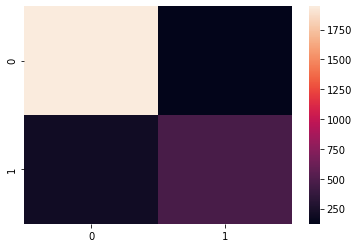

In [0]:
sns.heatmap(confusion_matrix(y_test, rf_prediction), annot=False)